In [1]:
import os
import ee
import geopandas as gpd
import numpy as np

import rasterio
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from skimage.transform import resize
from skimage.exposure import rescale_intensity

from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm

from rasterio.plot import reshape_as_image

In [2]:
from src.data.fetch import s2_from_gee, colorize_dynamic_world, read_gee_url

In [3]:
SERVICE_ACCOUNT = "forest-mapping@forest-mapping.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(
    SERVICE_ACCOUNT, "../forest-mapping-gee.json"
)
ee.Initialize(credentials)

In [4]:
tiles = gpd.read_file("../data/interim/washington_quarter_quads.shp")
tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    5772 non-null   int64   
 1   CELL_ID     5772 non-null   int64   
 2   CELL_NAME   5772 non-null   object  
 3   PRIMARY_ST  5772 non-null   object  
 4   CELL_MAPCO  5772 non-null   object  
 5   CELL_TYPE   5772 non-null   int64   
 6   CELL_ALLWA  5772 non-null   int64   
 7   CELL_DESCR  4 non-null      object  
 8   CELL_DIACR  0 non-null      object  
 9   GLOBALID    5772 non-null   object  
 10  SHAPE_Leng  5772 non-null   float64 
 11  SHAPE_Area  5772 non-null   float64 
 12  geometry    5772 non-null   geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 586.3+ KB


In [5]:
def get_dynamic_world(aoi, year):
    """Returns the most commonly-predicted land cover type for a given year
    from the Dynamic World dataset"""

    DW = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
    coll = DW.filterBounds(aoi).filterDate(f"{year}-04-01", f"{year}-09-30")
    img = coll.select(["label"]).reduce(ee.Reducer.mode())
    return img


def get_dynamic_world_download_url(bbox, year, epsg, scale=10):
    """Returns URL from which Dynamic World image can be downloaded."""
    xmin, ymin, xmax, ymax = bbox
    aoi = ee.Geometry.Rectangle(
        (xmin, ymin, xmax, ymax), proj=f"EPSG:{epsg}", evenOdd=True, geodesic=False
    )

    img = get_dynamic_world(aoi, year)
    url_params = dict(
        filePerBand=False,
        scale=scale,
        crs=f"EPSG:{epsg}",
        formatOptions={"cloudOptimized": True},
    )
    url = img.clip(aoi).getDownloadURL(url_params)

    return url


def dynamic_world_from_gee(bbox, year, epsg, scale=10):
    """Fetches a Dyanmic World raster from GEE.

    Parameters
    ----------
    bbox : list-like
      (xmin, ymin, xmax, ymax) coordinates for bounding box
    year : int
      year up to which Landtrendr time series will be calculated
    epsg : int
      EPSG code used to define projection
    """
    url = get_dynamic_world_download_url(bbox, year, epsg, scale)
    ras, profile = read_gee_url(url)

    return ras[0], profile

## An Illustrative Example
For a single tile, fetch the SENTINEL-2, LandTrendr, DEM, and NLCD imagery and plot it.

In [6]:
tile = tiles.sample(1)
bbox = tile.iloc[0]["geometry"].bounds
epsg = tiles.crs.to_epsg()
tile.iloc[0]

OBJECTID                                                   1738
CELL_ID                                                  256798
CELL_NAME                                         South Bend SW
PRIMARY_ST                                           Washington
CELL_MAPCO                                             46123-F7
CELL_TYPE                                                     1
CELL_ALLWA                                                    2
CELL_DESCR                                                 None
CELL_DIACR                                                 None
GLOBALID                 {6CEE3A1D-336B-4DAC-8CFA-65B0B653B681}
SHAPE_Leng                                                 0.25
SHAPE_Area                                             0.003906
geometry      POLYGON ((808407.8460128926 488497.95176883275...
Name: 1737, dtype: object

In [7]:
%%time
dw_ras, dw_profile = dynamic_world_from_gee(bbox, 2022, epsg)

CPU times: user 56.6 ms, sys: 0 ns, total: 56.6 ms
Wall time: 3.51 s


In [8]:
%%time
s2_ras, s2_profile = s2_from_gee(bbox, 2022, epsg)

CPU times: user 143 ms, sys: 54.6 ms, total: 198 ms
Wall time: 7.38 s


In [9]:
s2_rgb = reshape_as_image(np.clip(s2_ras[[12, 11, 10], :, :], 0, 3000) / 3000.0)

In [10]:
DW_COLOR_MAP = {
    "water": [65, 155, 223],  # 419BDF, water
    "trees": [57, 125, 73],  # 397D49, trees
    "grass": [136, 176, 83],  # 88B053, grass
    "flooded vegetation": [122, 135, 198],  # 7A87C6, flooded_vegetation
    "crops": [228, 150, 53],  # E49635, crops
    "shrub and scrub": [223, 195, 90],  # DFC35A, shrub_and_scrub
    "built": [196, 40, 27],  # C4281B, built
    "bare": [165, 155, 143],  # A59B8F, bare
    "snow and ice": [179, 159, 225],  # B39FE1, snow_and_ice
}

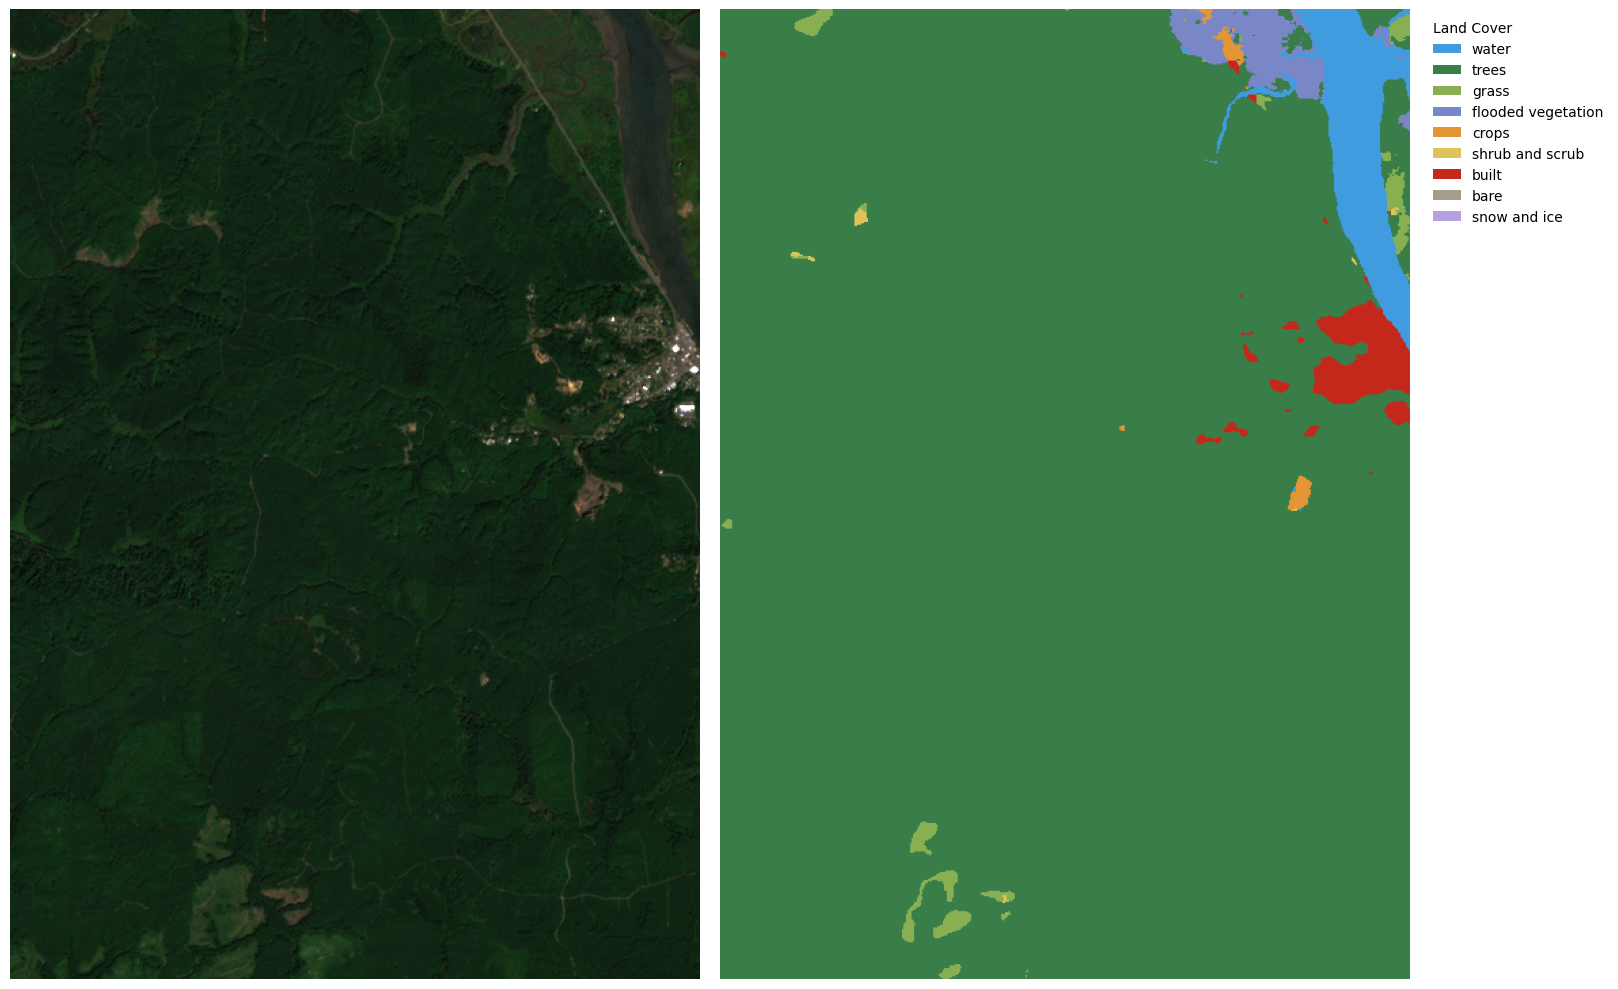

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs[0].imshow(s2_rgb)
axs[1].imshow(colorize_dynamic_world(dw_ras))

legend_elements = [
    Patch(facecolor=np.array(color) / 255.0, edgecolor="none", label=landcover)
    for landcover, color in DW_COLOR_MAP.items()
]

leg = axs[1].legend(
    handles=legend_elements,
    bbox_to_anchor=[1.30, 1.00],
    edgecolor="none",
    facecolor="none",
    title="Land Cover",
)
leg._legend_box.align = "left"
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

## Download Data for Tiles
With a helper function to download images, we'll iterate through all the tiles and fetch the data with some parallel processing.

In [12]:
def download_images(
    gdf_row,
    out_dir="../data/interim/washington_imagery",
    overwrite=False,
    epsg=2927,
    year=2022,
):
    bbox = gdf_row["geometry"].bounds
    cell_id = gdf_row["CELL_ID"]

    # get dynamic world and save to disk
    outfile = os.path.join(
        out_dir, "dynamic_world", f"{cell_id}_dynamicworld{year}.tif"
    )
    try:
        if not os.path.exists(outfile) or overwrite:
            ras, profile = dynamic_world_from_gee(bbox, year, epsg, scale=10)
            profile.update(compress="LZW")

            with rasterio.open(outfile, "w", **profile) as dst:
                dst.write(ras, 1)
                dst.write_colormap(
                    1,
                    {
                        0: [65, 155, 223],  # 419BDF, water
                        1: [57, 125, 73],  # 397D49, trees
                        2: [136, 176, 83],  # 88B053, grass
                        3: [122, 135, 198],  # 7A87C6, flooded_vegetation
                        4: [228, 150, 53],  # E49635, crops
                        5: [223, 195, 90],  # DFC35A, shrub_and_scrub
                        6: [196, 40, 27],  # C4281B, built
                        7: [165, 155, 143],  # A59B8F, bare
                        8: [179, 159, 225],  # B39FE1, snow_and_ice
                    },
                )
    except Exception as e:
        print("Failed on", cell_id, e)
        return cell_id

In [13]:
to_run = [row for _, row in tiles[["geometry", "CELL_ID"]].iterrows()]
to_run[0]["CELL_ID"]

221799

In [14]:
OUT_DIR = "../data/interim/washington_imagery"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "dynamic_world"), exist_ok=True)

In [15]:
with ProcessPoolExecutor(32) as executor:
    completed = []
    jobs = [executor.submit(download_images, row, year=2022) for row in to_run]

    for job in tqdm(as_completed(jobs), total=len(jobs)):
        completed.append(job.result())

  0%|          | 0/5772 [00:00<?, ?it/s]